In [12]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
dates_to_visualize = [
    "2018-09", "2018-10", "2018-11", "2018-12",
    "2019-01", "2019-02", "2019-03", "2019-04", "2019-05", "2019-06", "2019-07", "2019-08", "2019-09", "2019-10",
    "2019-11", "2019-12",
    "2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09", "2020-10",
    "2020-11", "2020-12",
    "2021-01", "2021-02", "2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10",
    "2021-11", "2021-12",
    "2022-01", "2022-02", "2022-03", "2022-04", "2022-05", "2022-06", "2022-07", "2022-08", "2022-09", "2022-10",
    "2022-11", "2022-12",
    "2023-01", "2023-02",
    # "2024-02",
]

In [4]:
available_data_files = list(Path("../data/httparchive_metrics/nel_deployment").glob("*.parquet"))

used_data_files = list(filter(lambda file: file.stem in dates_to_visualize, available_data_files))
used_data_files

[WindowsPath('../data/httparchive_metrics/nel_deployment/2018-09.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2018-10.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2018-11.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2018-12.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2019-02.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2019-03.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2019-04.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2019-05.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2019-06.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2019-07.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2019-08.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2019-09.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_deployment/2019-10.parquet'),
 WindowsPath

### Aggregate result to visualize

In [5]:
from results.result_utils import date_to_text_format, concat_data_from_files

result = concat_data_from_files(used_data_files)

result['total_crawled_domains'] = np.floor(pd.to_numeric(result['total_crawled_domains'], errors='coerce')).astype(
    'UInt32')
result['total_crawled_domains_with_nel'] = np.floor(
    pd.to_numeric(result['total_crawled_domains_with_nel'], errors='coerce')).astype('UInt32')
result['total_crawled_domains_with_correct_nel'] = np.floor(
    pd.to_numeric(result['total_crawled_domains_with_correct_nel'], errors='coerce')).astype('UInt32')

result['total_crawled_resources'] = np.floor(pd.to_numeric(result['total_crawled_resources'], errors='coerce')).astype(
    'UInt32')
result['total_crawled_resources_with_nel'] = np.floor(
    pd.to_numeric(result['total_crawled_resources_with_nel'], errors='coerce')).astype('UInt32')
result['total_crawled_resources_with_correct_nel'] = np.floor(
    pd.to_numeric(result['total_crawled_resources_with_correct_nel'], errors='coerce')).astype('UInt32')

result['date'] = result['date'].map(date_to_text_format)
result["nel_percentage"] = \
    np.uint32(result['total_crawled_domains_with_correct_nel']) / np.uint32(result['total_crawled_domains']) * 100

result

,date,total_crawled_resources,total_crawled_domains,total_crawled_resources_with_nel,total_crawled_domains_with_nel,total_crawled_resources_with_correct_nel,total_crawled_domains_with_correct_nel,nel_percentage
0,Sep 2018,189251267,2096799,18,3,2,2,0.00
0,Oct 2018,191683046,2093230,115,12,91,10,0.00
0,Nov 2018,162111236,2051626,1310,193,1244,187,0.01
0,Dec 2018,305842812,5291621,2862,384,2803,376,0.01
0,Feb 2019,351105672,5707189,2592,382,2532,370,0.01
0,Mar 2019,370358301,5790148,3607,391,3302,382,0.01
0,Apr 2019,427771979,6690439,1897971,74600,1897583,74590,1.11
0,May 2019,444564136,6950317,3726957,80904,3726553,80886,1.16
0,Jun 2019,443671879,6965303,2925168,79235,2924495,79214,1.14
0,Jul 2019,465370601,7160376,5279483,89049,5278664,89019,1.24


### DOMAINS queried within each month and those responding with valid NEL headers

In [6]:
result[['date', 'total_crawled_domains', 'total_crawled_domains_with_correct_nel', 'nel_percentage']]

,date,total_crawled_domains,total_crawled_domains_with_correct_nel,nel_percentage
0,Sep 2018,2096799,2,0.00
0,Oct 2018,2093230,10,0.00
0,Nov 2018,2051626,187,0.01
0,Dec 2018,5291621,376,0.01
0,Feb 2019,5707189,370,0.01
0,Mar 2019,5790148,382,0.01
0,Apr 2019,6690439,74590,1.11
0,May 2019,6950317,80886,1.16
0,Jun 2019,6965303,79214,1.14
0,Jul 2019,7160376,89019,1.24


C:\Users\Matej Jurík\AppData\Local\Temp\ipykernel_14712\2338382820.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


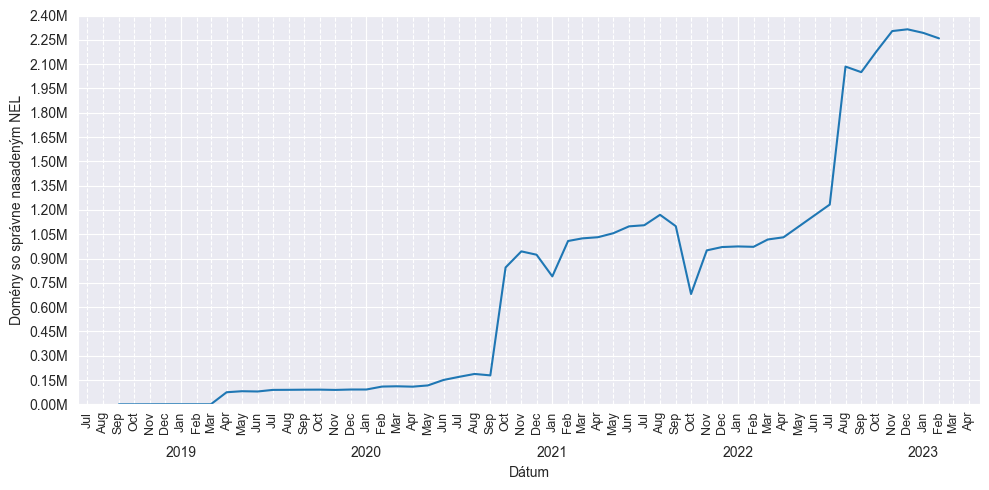

In [362]:
to_plot = result.copy()
to_plot['date_fmt'] = to_plot['date'].map(lambda date: pd.to_datetime(date))
# to_plot[('date_fmt')]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

sns.lineplot(to_plot, x='date_fmt', y='total_crawled_domains_with_correct_nel', ax=ax)

ax.xaxis.remove_overlapping_locs = False

years = mdates.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n\n%Y"))

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmt)

# ax.tick_params('x', length=4, width=4, which='both')
ax.tick_params(axis='x', which="minor", rotation=90, labelsize=9)


ax.set(xlabel='Dátum', ylabel='Domény so správne nasadeným NEL')
# plt.setp(ax.xaxis.get_majorticklabels(), )
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)

plt.grid(True, which='minor', linestyle='--',)
ax.set(ylim = (0,2_400_000))

# ax.yaxis.set_major_locator(ticker.FixedLocator([0, 100_000, 200_000, 500_000, 1_000_000, 1_200_000]))
ax.yaxis.set_major_locator(ticker.MultipleLocator(150_000))
ylabels = ['{:,.2f}'.format(x) + 'M' for x in ax.get_yticks()/1_000_000]
ax.set_yticklabels(ylabels)

fig.tight_layout()
# fig.subplots_adjust(bottom=0.2) # or whatever
plt.savefig('graphs/httparchive_nel_deployment.pdf')


C:\Users\Matej Jurík\AppData\Local\Temp\ipykernel_14712\1077883321.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(tick_labels)
C:\Users\Matej Jurík\AppData\Local\Temp\ipykernel_14712\1077883321.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(tick_labels)
C:\Users\Matej Jurík\AppData\Local\Temp\ipykernel_14712\1077883321.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(tick_labels)
C:\Users\Matej Jurík\AppData\Local\Temp\ipykernel_14712\1077883321.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(tick_labels)
C:\Users\Matej Jurík\AppData\Local\Temp\ipykernel_14712\

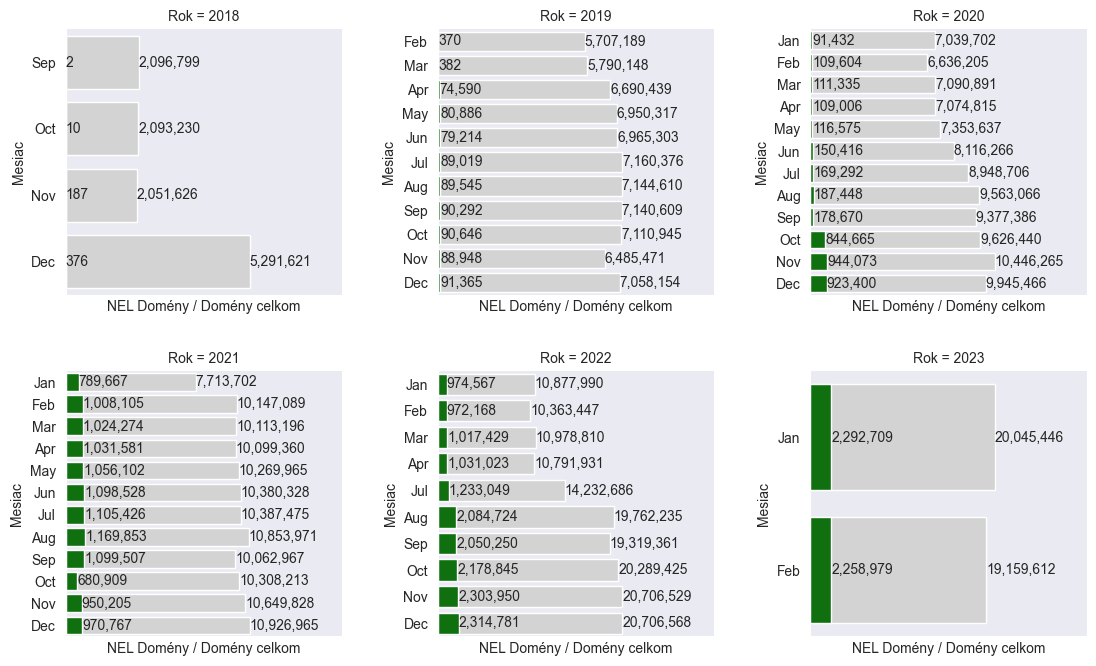

In [352]:

to_plot = result.copy()

to_plot['Rok'] = to_plot['date'].map(lambda date: date.split(" ")[1])

to_plot.index = to_plot['date']
to_plot.index = pd.to_datetime(to_plot.index, format="%b %Y")

idx = pd.date_range('01-01-2018', '31-12-2024', freq='MS')
to_plot.reindex(idx, fill_value=0)

to_plot.drop(columns=['date'], inplace=True)
to_plot.reset_index(inplace=True)

g = sns.FacetGrid(to_plot, col='Rok', col_wrap=3, margin_titles=True, sharex=False, sharey=False, height=3.5, aspect=1.1)

g.map_dataframe(sns.barplot, x="total_crawled_domains", y="date", color="lightgray")
for idx, (col_val, ax) in enumerate(g.axes_dict.items()):
    ax.bar_label(ax.containers[-1], fmt='{:,.0f}', label_type='edge')
    ax.set(xlim=(ax.get_ylim()[0], max(ax.containers[-1].datavalues) * 1.5))



g.map_dataframe(sns.barplot, x="total_crawled_domains_with_correct_nel", y="date", color="green")
for idx, (col_val, ax) in enumerate(g.axes_dict.items()):
    ax.bar_label(ax.containers[-1], fmt='{:,.0f}', label_type='edge')


for idx, (col_val, ax) in enumerate(g.axes_dict.items()):
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)

    # ax.xaxis.remove_overlapping_locs = False
    ax.xaxis.set_major_locator(ticker.NullLocator())

    # months = mdates.MonthLocator()
    # months_fmt = mdates.DateFormatter('%b')
    # ax.yaxis.set_major_locator(months)
    # ax.yaxis.set_major_formatter(months_fmt)

    # This just would not work forever... I really AM sorry, no more time to waste
    tick_labels = [date_to_text_format("-".join(x.get_text().split('-')[:2])).split(' ')[0] for x in ax.get_yticklabels()]
    ax.set_yticklabels(tick_labels)


    ax.set(xlabel='NEL Domény / Domény celkom', ylabel='Mesiac')
    fig.tight_layout()

plt.savefig('graphs/httparchive_nel_deployment_ratios.pdf')


### RESOURCES queried within each month and those with valid NEL headers

In [8]:
result['nel_resource_percentage'] = result['total_crawled_resources_with_correct_nel'] / result[
    'total_crawled_resources'] * 100
result[['date', 'total_crawled_resources', 'total_crawled_resources_with_correct_nel', 'nel_resource_percentage']]

,date,total_crawled_resources,total_crawled_resources_with_correct_nel,nel_resource_percentage
0,Sep 2018,189251267,2,0.00
0,Oct 2018,191683046,91,0.00
0,Nov 2018,162111236,1244,0.00
0,Dec 2018,305842812,2803,0.00
0,Feb 2019,351105672,2532,0.00
0,Mar 2019,370358301,3302,0.00
0,Apr 2019,427771979,1897583,0.44
0,May 2019,444564136,3726553,0.84
0,Jun 2019,443671879,2924495,0.66
0,Jul 2019,465370601,5278664,1.13


### Incorrect NEL deployment

In [9]:
result['domains_with_incorrect_nel'] = result['total_crawled_domains_with_nel'] - result[
    'total_crawled_domains_with_correct_nel']
result['resources_with_incorrect_nel'] = result['total_crawled_resources_with_nel'] - result[
    'total_crawled_resources_with_correct_nel']

# TODO ratio to the correct NEL

result[['date', 'domains_with_incorrect_nel', 'resources_with_incorrect_nel']]

,date,domains_with_incorrect_nel,resources_with_incorrect_nel
0,Sep 2018,1,16
0,Oct 2018,2,24
0,Nov 2018,6,66
0,Dec 2018,8,59
0,Feb 2019,12,60
0,Mar 2019,9,305
0,Apr 2019,10,388
0,May 2019,18,404
0,Jun 2019,21,673
0,Jul 2019,30,819
